In [1]:
import sys
import time
import copy

import numpy as np
from imageio import imread
from scipy.ndimage.filters import gaussian_filter
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam, LBFGS
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose
from torchvision.models import vgg19

import pylab as plt
plt.ion()

from tqdm import tqdm
tqdm.monitor_interval = 0

from models import gram_matrix, patch_match, downsampling, cosine_similarity
from data_utils import read_img

In [2]:
style_fn = 'data/0_target.jpg'
naive_fn = 'data/0_naive.jpg'
mask_fn = 'data/0_c_mask_dilated.jpg'
tmask_fn = 'data/0_c_mask.jpg'

torch.manual_seed(316)
torch.cuda.manual_seed_all(316)

In [3]:
loader = ToTensor()  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.cuda()

def imshow(tensor, title = None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001) # pause a bit so that plots are updated

unloader = ToPILImage()  # reconvert into PIL image
#transform = Normalizetransform(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.Size([1, 3, 682, 700])
torch.Size([1, 3, 682, 700])
torch.Size([1, 682, 700])
torch.Size([1, 682, 700])


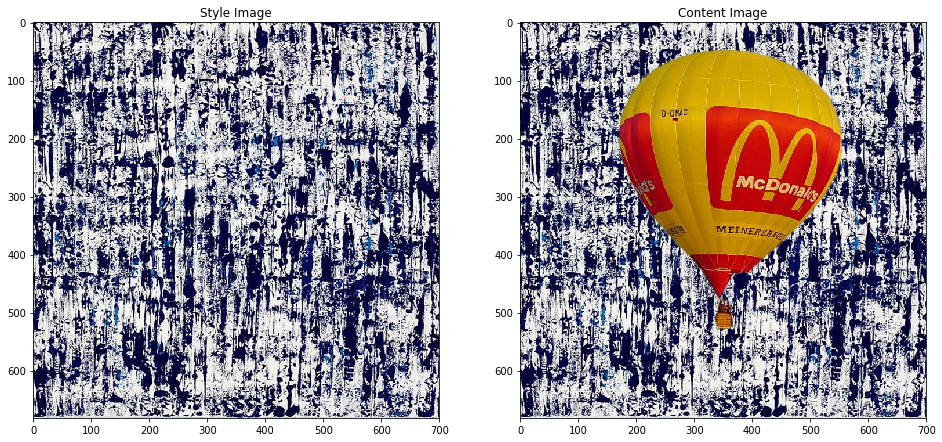

In [4]:
style_img = image_loader(style_fn)
content_img = image_loader(naive_fn)
mask_img = imread(mask_fn).astype(np.float32)
tmask_img = imread(tmask_fn).astype(np.float32)
if mask_img.shape[-1] == 3:
    mask_img = mask_img[..., 0]
if tmask_img.shape[-1] == 3:
    tmask_img = tmask_img[..., 0]
tmask_img = gaussian_filter(tmask_img, sigma = 3)
tmask_img = torch.from_numpy(tmask_img).unsqueeze(0).cuda() / 255.0
mask_img = torch.from_numpy(mask_img).unsqueeze(0).cuda() / 255.0

print(style_img.shape)
print(content_img.shape)
print(mask_img.shape)
print(tmask_img.shape)

#content_img_original = content_img.clone()
#content_img = content_img.requires_grad_(True)

plt.figure(figsize = (16, 8))
plt.subplot(121)
imshow(style_img, title='Style Image')

plt.subplot(122)
imshow(content_img, title='Content Image')

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target, mask):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.mask = mask
        self.target = target.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x * self.mask, self.target * self.mask)
        return x

class StyleLoss(nn.Module):

    def __init__(self, target_feature, mask):
        super(StyleLoss, self).__init__()
        self.mask = mask
        self.target = (gram_matrix(target_feature * self.mask).float() / self.mask.sum()).detach()

    def forward(self, x):
        G = gram_matrix(x * self.mask).float() / self.mask.sum()
        self.loss = F.mse_loss(G, self.target)
        return x

normalization_mean = torch.tensor([103.939, 116.779, 123.68]).cuda()
normalization_std = torch.tensor([1.0, 1.0, 1.0]).cuda()

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img * 255.0 - self.mean) / self.std

In [6]:
import torch.utils.model_zoo as model_zoo
cnn = vgg19()
cnn.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'))
cnn = cnn.features.cuda().eval()

In [7]:
def get_style_model_and_losses(cnn, normalization, style_img, content_img, mask_img, content_layers = ['relu4_1'],
                               style_layers = ['relu3_1', 'relu4_1', 'relu5_1']):

    cnn = copy.deepcopy(cnn)
    normalization = copy.deepcopy(normalization)

    mask = mask_img.unsqueeze(0)
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 1 # increment every time we see a pool
    j = 0 # increment every time we see a conv, reset to 0 every time we see a pool
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            j += 1
            name = 'conv{}_{}'.format(i, j)
            mask = F.avg_pool2d(mask, 3, stride = 1, padding = 1)
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(i, j)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace = False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool{}_{}'.format(i, j)
            mask = downsampling(mask, scale_factor = 0.5)
            i += 1
            j = 0
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}_{}'.format(i, j)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        print("Adding " + name)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target, mask.expand_as(target))

            model.add_module("content_loss{}_{}".format(i, j), content_loss)
            content_losses.append(content_loss)

            print("Adding content loss at " + name)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img)
            target_content = model(content_img).detach()
            target_match = patch_match(target_content, target_feature, patch_size = 3).detach()
            style_loss = StyleLoss(target_match, mask.expand_as(target_match))

            model.add_module("style_loss{}_{}".format(i, j), style_loss)
            style_losses.append(style_loss)

            print('no matching: ', torch.mean(cosine_similarity(target_content, target_feature)))
            print('matched: ', torch.mean(cosine_similarity(target_content, target_match)))
            print("Adding style loss at " + name)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses    

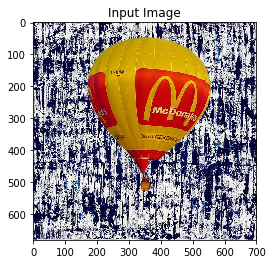

In [8]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [9]:
def run_style_transfer(cnn, normalization, content_img, style_img, input_img, mask_img, num_steps = 1000,
                       style_weight = 100, content_weight = 5):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization, style_img, content_img, mask_img)
    optimizer = LBFGS([input_img.requires_grad_()], max_iter = num_steps, lr = 1)

    print('Optimizing..')
    run = [0]
    def closure():
        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        if run[0] % 100 == 0:
            print("run {}:".format(run))
            print('Style Loss : {} Content Loss: {}'.format(style_score.item(), content_score.item()))
            print()
            plt.figure(figsize = (8, 8))
            #imshow(input_img.clone())
        run[0] += 1

        return style_score + content_score

    optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [10]:
output = run_style_transfer(cnn, Normalization(normalization_mean, normalization_std),
                            content_img, style_img, input_img, mask_img)

output = tmask_img * output + (1 - tmask_img) * style_img
plt.figure(figsize = (8, 8))
imshow(output)

/home/thangbm/tf/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/thangbm/tf/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Building the style transfer model..
Adding conv1_1
Adding relu1_1
Adding conv1_2
Adding relu1_2
Adding pool1_2
Adding conv2_1
Adding relu2_1
Adding conv2_2
Adding relu2_2
Adding pool2_2
Adding conv3_1
Adding relu3_1
no matching:  tensor(0.8420, grad_fn=<MeanBackward1>)
matched:  tensor(0.9172)
Adding style loss at relu3_1
Adding conv3_2
Adding relu3_2
Adding conv3_3
Adding relu3_3
Adding conv3_4
Adding relu3_4
Adding pool3_4
Adding conv4_1
Adding relu4_1
Adding content loss at relu4_1
no matching:  tensor(0.7789, grad_fn=<MeanBackward1>)
matched:  tensor(0.8338)
Adding style loss at relu4_1
Adding conv4_2
Adding relu4_2
Adding conv4_3
Adding relu4_3
Adding conv4_4
Adding relu4_4
Adding pool4_4
Adding conv5_1
Adding relu5_1
no matching:  tensor(0.7237, grad_fn=<MeanBackward1>)
matched:  tensor(0.7607)
Adding style loss at relu5_1
Adding conv5_2
Adding relu5_2
Adding conv5_3
Adding relu5_3
Adding conv5_4
Adding relu5_4
Adding pool5_4
Optimizing..
run [0]:
Style Loss : 555677.125 Content 

KeyboardInterrupt: 

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [ ]:
print(torch.sum(mask_img))